# cu_inj Live

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
from lcls_live.datamaps import get_datamaps
from lcls_live.archiver import lcls_archiver_restore

from lcls_live.tools import isotime

import os

In [4]:
BEAMPATH = 'cu_spec'

## Datamaps, and all PVs needed

In [5]:
DM = get_datamaps(BEAMPATH)

# Hack in 10 Hz
df = DM['bpms'].data
DM['bpms'].data['pvname'] = [name[:-2]+'TH' for name in df['pvname']]

DM.keys()

dict_keys(['bpms', 'correctors', 'quad', 'linac'])

In [6]:
# datamaps to exclude
DENYLIST = ['correctors', 'linac'] #, 'quad']

In [7]:
# PVs needed
PVLIST =  []
for name, dm in DM.items():
    if name in DENYLIST:
        continue
    PVLIST.extend(dm.pvlist)
PVLIST = list(set(PVLIST))
len(PVLIST)

46

## EPICS

In [8]:
import epics
from time import sleep, time

In [9]:
MONITOR = {pvname:epics.PV(pvname) for pvname in PVLIST}
sleep(5) # Wait for all to connect

In [10]:
def get_pvdata():   
    itime = isotime()
    pvdata =  {k:MONITOR[k].get() for k in MONITOR}
    return pvdata
PVDATA = get_pvdata()

In [11]:
# Check for bad PVs
bad = set()
for k, v in PVDATA.items():
    if v is None:
        bad.add(k.split(':')[2])
        print(k)
assert len(bad) == 0

# Tao conveniences

In [12]:
def tao_commands(pvdata):
    cmds = []
    for name, dm in DM.items():
        cmds.extend(dm.as_tao(pvdata))
    return cmds

In [13]:
def save_cmds(cmds, filename='cmds.tao'): # Write to file for running with vanilla Tao
    with open(filename, 'w') as f:
        f.write('set global lattice_calc_on = F\n')
        f.write('set global plot_on = F\n')    
        for cmd in CMDS:
            f.write(cmd+'\n')
        f.write('set global lattice_calc_on = T\n')        
        f.write('set global plot_on = T\n')   

In [14]:
def toggle_beam():
    tao.cmd('set global track_type = beam') 
    tao.cmd('set global track_type = single') 

## Form commands using PVDATA and datamaps

In [15]:
tao_commands(PVDATA)[0:5]

['set data orbit.x[1]|meas  = 0.001 * 0.015410363674163818',
 'set data orbit.x[2]|meas  = 0.001 * 0.17051580548286438',
 'set data orbit.x[3]|meas  = 0.001 * -0.014728419482707977',
 'set data orbit.x[4]|meas  = 0.001 * 0.01716996729373932',
 'set data orbit.x[5]|meas  = 0.001 * 0.04663494974374771']

# Start Tao

In [16]:
from pytao import Tao

In [18]:
MODEL_ROOT = f'$LCLS_LATTICE/bmad/models/{BEAMPATH}/'
init = f'-init {MODEL_ROOT}/tao.init'
tao = Tao(init)
init

'-init $LCLS_LATTICE/bmad/models/cu_spec//tao.init'

In [19]:
#tao.cmd(f'call {MODEL_ROOT}/scripts/Activate_CSR.tao');

In [21]:
%%time
# Turn on the beam
tao.cmd('set beam_init n_particle = 10000')
toggle_beam()

CPU times: user 1.47 s, sys: 147 ms, total: 1.62 s
Wall time: 513 ms


In [22]:
%%tao
place floor none
place top2 bpm_orbit
place middle2 bunch_sigma_xy 

sc top2 -2 2

set graph middle2 y%label = "\gs\fn\dx\u, \gs\fn\dy\u (\gmm)"
set curve middle2.g.x y_axis_scale_factor = 1e6
set curve middle2.g.y y_axis_scale_factor = 1e6
sc middle2 ! 0 600


x-a all s 

-------------------------
Tao> place floor none
-------------------------
Tao> place top2 bpm_orbit
-------------------------
Tao> place middle2 bunch_sigma_xy 
-------------------------
Tao> 
-------------------------
Tao> sc top2 -2 2
-------------------------
Tao> 
-------------------------
Tao> set graph middle2 y%label = "\gs\fn\dx\u, \gs\fn\dy\u (\gmm)"
-------------------------
Tao> set curve middle2.g.x y_axis_scale_factor = 1e6
-------------------------
Tao> set curve middle2.g.y y_axis_scale_factor = 1e6
-------------------------
Tao> sc middle2 ! 0 600
-------------------------
Tao> 
-------------------------
Tao> 
-------------------------
Tao> x-a all s 
-------------------------
Tao> 


In [23]:
%%tao
place top2 energy
x-a all s 
sc

-------------------------
Tao> place top2 energy
-------------------------
Tao> x-a all s 
-------------------------
Tao> sc
-------------------------
Tao> 


In [24]:
#tao.cmd(f'call {MODEL_ROOT}/scripts/SC.tao')

# Continuous loop

In [30]:
def run1():
    #sleep(.001)
    t1 = time()
    pvdata = get_pvdata()
    cmds = tao_commands(pvdata)
    tao.cmd('set global plot_on = F;set global lattice_calc_on = F')
    tao.cmds(cmds); # Apply

    tao.cmd('set global lattice_calc_on = T')
    tao.cmd('set global plot_on = T')
    toggle_beam()
    
    dt = time()-t1
    #print(dt)    


In [31]:
%%time
run1()

CPU times: user 1.34 s, sys: 123 ms, total: 1.47 s
Wall time: 414 ms


In [32]:
while True:
    run1()

KeyboardInterrupt: 

In [33]:
%%time
#toggle on and off
tao.cmd('set global track_type = beam', raises=False) 
tao.cmd('set global track_type = single') 

CPU times: user 1.37 s, sys: 124 ms, total: 1.49 s
Wall time: 394 ms


[]

In [34]:
%%tao
place top2 beambeta
place middle2 bunch_sigma_xy
x-a all s
sc

-------------------------
Tao> place top2 beambeta
-------------------------
Tao> place middle2 bunch_sigma_xy
-------------------------
Tao> x-a all s
-------------------------
Tao> sc
-------------------------
Tao> 


## Get particles 

In [36]:
from pmd_beamphysics import ParticleGroup

In [37]:
P = ParticleGroup(data=tao.bunch_data('OTR2'))
# Select out live particles
P = P[P.status==1]
P.drift_to_z()

Text(0.5, 1.0, 'OTR2')

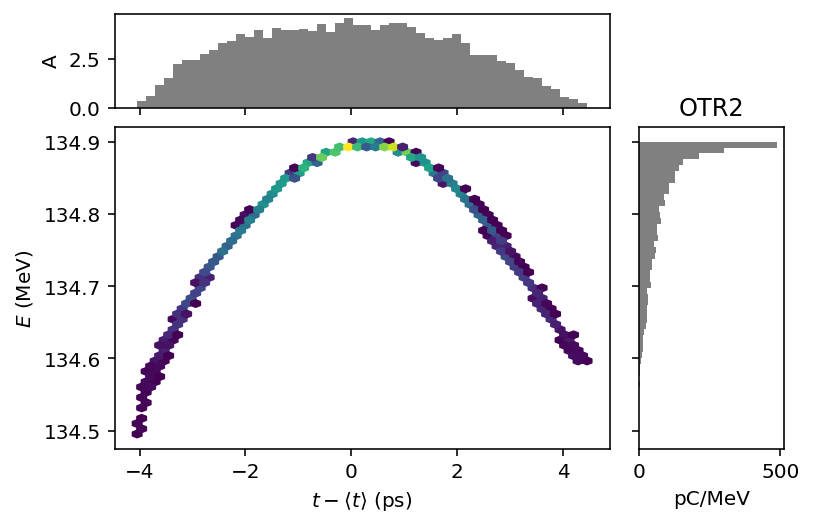

In [39]:
P.plot('delta_t', 'energy')
plt.title('OTR2')

In [ ]:
P.plot('x', 'y')

In [ ]:
P.plot('z', 'x')

In [ ]:
# Make a function for this
def get_beam(ele):
    P = ParticleGroup(data=tao.bunch_data(ele))
    # Select out live particles
    P = P[P.status==1]    
    
    return P

In [ ]:
P1 = get_beam('OTR2')
P1.plot('delta_t', 'delta_energy')

In [ ]:
P2 = get_beam('OTR2')
P2.plot('x', 'y')

# Get giant table of bunch stats

In [ ]:
import pandas as pd

In [ ]:
# Get list of indices
IX = tao.lat_list('*', 'ele.ix_ele')

# Stop before the dump
S_STOP = tao.ele_head('OTR2')['s']

stats = []
for ele in IX:
    d = tao.bunch_params(ele)
    # Skipl ones with no beam
    if d['charge_live'] == 0:
        continue
    
    if d['s'] > S_STOP:
        break
        
    stats.append(d)

df = pd.DataFrame(stats)#.set_index('ix_ele')
df

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(df['s'], df['sigma_x']*1e6, label=r'$\sigma_x$')
plt.plot(df['s'], df['sigma_y']*1e6, label=r'$\sigma_y$')
plt.xlabel('s (m)')
plt.ylabel('beam sizes (µm)')
plt.legend();

In [ ]:
# Get an array of where the beam is saved
s_saved = np.array(df[df['beam_saved']]['s'])

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(df['s'], df['norm_emit_x']*1e6, label=r'$\epsilon_{n,x}$')
plt.plot(df['s'], df['norm_emit_y']*1e6, label=r'$\epsilon_{n,y}$')
plt.xlabel('s (m)')
plt.ylabel('Beam emittance(mm-mrad)')


# This is where the beam is saved
plt.scatter(s_saved, np.ones(len(s_saved))*0, color = 'black', marker = 'x')


plt.legend();